# Feature Extraction and Fully-connected Layers Training

Extract features from each spectrogram using pre-trained CNNs. Then use extracted features to train last 2 fully-connected layers.

Our final model -- 3/4/5 local feature extractors + 2 fully-connected layers with softmax output

In [2]:
import os    
os.environ['THEANO_FLAGS'] = "floatX=float32,device=cuda,exception_verbosity=high"
import theano

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
/tmp/try_flags_DeFknr.c:4:19: fatal error: cudnn.h: No such file or directory
 #include <cudnn.h>
                   ^
compilation terminated.

Mapped name None to device cuda: Tesla K80 (0000:00:04.0)


In [3]:
import keras

Using Theano backend.


In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
from keras.layers import Input, Dense, merge, Flatten, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D
from keras.models import Model
from keras.regularizers import l2
import matplotlib.pyplot as plt
from keras.utils.visualize_util import plot
import os

## Local Feature Extractor

In [5]:
def gen_cnn(seg_length, pool_sizes_hori):
    '''
    The function for building CNNs.
    Each CNN model handles one segment of mel-spectrograms at a time.
    The size of mel-spectrogram sgements is defined by "seg_length"
    "seg_length" and pooling layer sizes are set adjusting to different scales.
    '''
    psh = [0] + pool_sizes_hori # padding at front for index alignment
    
    # input
    x = Input(shape=(1, 96, seg_length))

    # 1st conv layer
    conv1 = Convolution2D(32, 3, 3, border_mode='same', init='he_normal', name='conv1_{}'.format(seg_length), trainable=False)(x)
    conv1 = keras.layers.advanced_activations.ELU(alpha=1.0)(conv1)
    conv1 = MaxPooling2D(pool_size=(2, psh[1]))(conv1)
    avg1 = GlobalAveragePooling2D()(conv1)

    # 2nd conv layer
    conv2 = Convolution2D(32, 3, 3, border_mode='same', init='he_normal', name='conv2_{}'.format(seg_length), trainable=False)(conv1)
    conv2 = keras.layers.advanced_activations.ELU(alpha=1.0)(conv2)
    conv2 = MaxPooling2D(pool_size=(3, psh[2]))(conv2)
    avg2 = GlobalAveragePooling2D()(conv2)

    # 3rd conv layer
    conv3 = Convolution2D(32, 3, 3, border_mode='same', init='he_normal', name='conv3_{}'.format(seg_length), trainable=False)(conv2)
    conv3 = keras.layers.advanced_activations.ELU(alpha=1.0)(conv3)
    conv3 = MaxPooling2D(pool_size=(2, psh[3]))(conv3)
    avg3 = GlobalAveragePooling2D()(conv3)

    # 4th conv layer
    conv4 = Convolution2D(32, 3, 3, border_mode='same', init='he_normal', name='conv4_{}'.format(seg_length), trainable=False)(conv3)
    conv4 = keras.layers.advanced_activations.ELU(alpha=1.0)(conv4)
    conv4 = MaxPooling2D(pool_size=(2, psh[4]))(conv4)
    avg4 = GlobalAveragePooling2D()(conv4)

    # Concatenate 5 intermediate outputs
    concatenated = merge([avg1, avg2, avg3, avg4], mode='concat', concat_axis=1)
    
    # define model
    model = Model(input=x, output=concatenated)
    
    # load pre-trained weights
    model.load_weights(PATH_WEIGHTS, by_name=True)
    
    return model

## Load Dataset

Load "raw" dataset (data whose features to be extracted).
- `X_train`: Training data
- `Y_train`: Labels of training data
- `X_test`: Heldout test data
- `Y_test`: Labels of test data

In [9]:
# Load Train Dataset (X_train, Y_train)
X_train = np.load('./dataset/X_train.npy')
Y_train_pre = np.load('./dataset/Y_train.npy').astype(int)

Y_train = np.zeros((Y_train_pre.shape[0], 10))
Y_train[np.arange(Y_train_pre.shape[0]), Y_train_pre] = 1

# Load Test Dataset (X_test, Y_test)
X_test = np.load('./dataset/X_test.npy')
Y_test_pre = np.load('./dataset/Y_test.npy').astype(int)

Y_test = np.zeros((Y_test_pre.shape[0], 10))
Y_test[np.arange(Y_test_pre.shape[0]), Y_test_pre] = 1

print X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

(900, 1, 96, 1360) (900, 10) (100, 1, 96, 1360) (100, 10)


## Extract Feature

In [ ]:
def extract_feature(X, seg_lengths, pool_sizes_horis, flag_save=True, tr_te='tr'):
    '''
    Extract features in different scales for all mel-spectrograms.
    Inputs:
        - X: spectrograms to be processed
        - seg_lengths, pool_sizes_horis: parameters to build CNN models
        - flag_save: Set True to save extracted feature vactors
    Return:
        extracted features from all images in X
    '''
    # Build cnn model and load pre-trained weights
    models = []
    for i, seg_length in enumerate(seg_lengths):
        pool_sizes_hori = pool_sizes_horis[i] # select pool layer sizes
        cnn = gen_cnn(seg_length, pool_sizes_hori) # generate model
        PATH_WEIGHTS = './weights/local_cnn_{}.h5'.format(seg_length)
        cnn.load_weights(PATH_WEIGHTS, by_name=True) # load pre-trained weights
        models.append((cnn, seg_length))
    
    num_pics, length = X.shape[0], X.shape[3]
    num_models = len(models) # Number of CNNs
    new_X = np.zeros((num_pics, 128*num_models))
    for i, params in enumerate(models):
        cnn, seg_length = params # read model and corresponding seg_length
        features = np.zeros((num_pics, 128))
        for j in xrange(length/seg_length):
            feature = cnn.predict(X[:, :, :, j*seg_length:(j+1)*seg_length]) # extract feature using cnn
            features += feature
        features /= length/seg_length # compute mean on feature vectors among all segments
        assert features.shape == (num_pics, 128)
        new_X[:, i*128:(i+1)*128] = features 
        
    if flag_save:
        if not os.path.exists('./local_features/'):
            os.mkdir('./local_features/')
        if tr_te == 'tr':
            np.save('./local_features/X_train_extracted.npy', new_X)
        else:
            np.save('./local_features/X_test_extracted.npy', new_X)
    return new_X

In [ ]:
# model parameters
seg_lengths = [30, 60, 120, 240]
pool_sizes_horis = [[2, 2, 2, 2], [3, 2, 2, 2], [3, 3, 2, 2], [4, 4, 3, 2]] # sizes of pooling layers (in horizontal direction)

# Call function to extract feature from each song clip
X_train_ext = extract_feature(X_train, seg_lengths, pool_sizes_horis)
X_test_ext = extract_feature(X_test, seg_lengths, pool_sizes_horis, tr_te='te')

In [7]:
# -- Or load the features if extraction has been done before
X_train_ext = np.load('./local_features/X_train_extracted.npy') # "ext": extracted feature
X_test_ext = np.load('./local_features/X_test_extracted.npy')

In [8]:
X_test_ext.shape

(100, 512)

In [29]:
# Merge train & test data together for cross-validation
X_ext = np.concatenate((X_train_ext, X_test_ext), axis=0)
Y_ext = np.concatenate((Y_train, Y_test), axis=0)

In [30]:
print X_ext.shape, Y_ext.shape

(1000, 512) (1000, 10)


## Global Classifier -- 2 Dense Layers 

In [31]:
def gen_classifier(lambd=0.2):
    '''
    Generate a "global" classifier with 2 hidden dense layers and dropout regularization.
    '''
    # Model input
    x = Input(shape=(512,))
    
    # First hidden layer
    dense1 = Dense(256, input_shape=[512], activation='relu')(x)
    dr1 = Dropout(lambd)(dense1)
    
    # Model output
    out = Dense(10, input_shape=[128], activation='softmax')(dr1)
    
    # Create model
    model = Model(input=x, output=out)
    
    return model

In [19]:
# Compile and Train Model
classifier = gen_classifier()
# classifier.summary()

In [37]:
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_his = classifier.fit(X_train_ext, Y_train, validation_data=(X_test_ext, Y_test), nb_epoch=500, verbose=1)

Train on 900 samples, validate on 100 samples
Epoch 1/500
900/900 [==============================] - 0s - loss: 0.1759 - acc: 0.9267 - val_loss: 1.0935 - val_acc: 0.7700
Epoch 2/500
900/900 [==============================] - 0s - loss: 0.1641 - acc: 0.9467 - val_loss: 1.3945 - val_acc: 0.7500
Epoch 3/500
900/900 [==============================] - 0s - loss: 0.1516 - acc: 0.9400 - val_loss: 1.1651 - val_acc: 0.7400
Epoch 4/500
900/900 [==============================] - 0s - loss: 0.1254 - acc: 0.9511 - val_loss: 1.2294 - val_acc: 0.7400
Epoch 5/500
900/900 [==============================] - 0s - loss: 0.1727 - acc: 0.9411 - val_loss: 1.1631 - val_acc: 0.7700
Epoch 6/500
900/900 [==============================] - 0s - loss: 0.1638 - acc: 0.9367 - val_loss: 1.1817 - val_acc: 0.8100
Epoch 7/500
900/900 [==============================] - 0s - loss: 0.1686 - acc: 0.9444 - val_loss: 1.0702 - val_acc: 0.7800
Epoch 8/500
900/900 [==============================] - 0s - loss: 0.1516 - acc: 0.9478

900/900 [==============================] - 0s - loss: 0.1578 - acc: 0.9433 - val_loss: 1.4339 - val_acc: 0.7500
Epoch 67/500
900/900 [==============================] - 0s - loss: 0.1315 - acc: 0.9622 - val_loss: 1.3324 - val_acc: 0.7400
Epoch 68/500
900/900 [==============================] - 0s - loss: 0.1212 - acc: 0.9644 - val_loss: 1.3552 - val_acc: 0.7500
Epoch 69/500
900/900 [==============================] - 0s - loss: 0.1271 - acc: 0.9544 - val_loss: 1.5080 - val_acc: 0.7400
Epoch 70/500
900/900 [==============================] - 0s - loss: 0.1618 - acc: 0.9378 - val_loss: 1.4390 - val_acc: 0.7500
Epoch 71/500
900/900 [==============================] - 0s - loss: 0.1445 - acc: 0.9444 - val_loss: 1.4112 - val_acc: 0.7000
Epoch 72/500
900/900 [==============================] - 0s - loss: 0.1446 - acc: 0.9556 - val_loss: 1.4561 - val_acc: 0.7600
Epoch 73/500
900/900 [==============================] - 0s - loss: 0.2283 - acc: 0.9233 - val_loss: 1.3268 - val_acc: 0.7200
Epoch 74/500


900/900 [==============================] - 0s - loss: 0.1473 - acc: 0.9433 - val_loss: 1.6401 - val_acc: 0.7200
Epoch 132/500
900/900 [==============================] - 0s - loss: 0.1243 - acc: 0.9589 - val_loss: 1.4785 - val_acc: 0.7600
Epoch 133/500
900/900 [==============================] - 0s - loss: 0.1240 - acc: 0.9556 - val_loss: 1.5686 - val_acc: 0.7500
Epoch 134/500
900/900 [==============================] - 0s - loss: 0.1795 - acc: 0.9344 - val_loss: 1.4049 - val_acc: 0.7400
Epoch 135/500
900/900 [==============================] - 0s - loss: 0.1880 - acc: 0.9344 - val_loss: 1.5964 - val_acc: 0.7000
Epoch 136/500
900/900 [==============================] - 0s - loss: 0.1918 - acc: 0.9300 - val_loss: 1.4639 - val_acc: 0.7100
Epoch 137/500
900/900 [==============================] - 0s - loss: 0.2617 - acc: 0.9133 - val_loss: 1.4783 - val_acc: 0.7500
Epoch 138/500
900/900 [==============================] - 0s - loss: 0.2305 - acc: 0.9178 - val_loss: 1.1596 - val_acc: 0.7800
Epoch 

900/900 [==============================] - 0s - loss: 0.1264 - acc: 0.9567 - val_loss: 1.2025 - val_acc: 0.7500
Epoch 197/500
900/900 [==============================] - 0s - loss: 0.1087 - acc: 0.9633 - val_loss: 1.5698 - val_acc: 0.7600
Epoch 198/500
900/900 [==============================] - 0s - loss: 0.1310 - acc: 0.9556 - val_loss: 1.1589 - val_acc: 0.7500
Epoch 199/500
900/900 [==============================] - 0s - loss: 0.0971 - acc: 0.9711 - val_loss: 1.3712 - val_acc: 0.7500
Epoch 200/500
900/900 [==============================] - 0s - loss: 0.1990 - acc: 0.9322 - val_loss: 1.3961 - val_acc: 0.7400
Epoch 201/500
900/900 [==============================] - 0s - loss: 0.2136 - acc: 0.9233 - val_loss: 1.3586 - val_acc: 0.7500
Epoch 202/500
900/900 [==============================] - 0s - loss: 0.1413 - acc: 0.9489 - val_loss: 1.3883 - val_acc: 0.7700
Epoch 203/500
900/900 [==============================] - 0s - loss: 0.1494 - acc: 0.9578 - val_loss: 1.2516 - val_acc: 0.7700
Epoch 

900/900 [==============================] - 0s - loss: 0.1841 - acc: 0.9300 - val_loss: 1.1861 - val_acc: 0.7400
Epoch 262/500
900/900 [==============================] - 0s - loss: 0.2204 - acc: 0.9256 - val_loss: 1.2914 - val_acc: 0.7100
Epoch 263/500
900/900 [==============================] - 0s - loss: 0.2246 - acc: 0.9144 - val_loss: 1.2916 - val_acc: 0.7600
Epoch 264/500
900/900 [==============================] - 0s - loss: 0.2262 - acc: 0.9111 - val_loss: 1.5674 - val_acc: 0.7200
Epoch 265/500
900/900 [==============================] - 0s - loss: 0.2104 - acc: 0.9178 - val_loss: 1.2782 - val_acc: 0.7800
Epoch 266/500
900/900 [==============================] - 0s - loss: 0.1927 - acc: 0.9378 - val_loss: 1.4304 - val_acc: 0.7400
Epoch 267/500
900/900 [==============================] - 0s - loss: 0.1901 - acc: 0.9256 - val_loss: 1.6042 - val_acc: 0.7300
Epoch 268/500
900/900 [==============================] - 0s - loss: 0.1982 - acc: 0.9222 - val_loss: 1.3557 - val_acc: 0.7400
Epoch 

900/900 [==============================] - 0s - loss: 0.1854 - acc: 0.9344 - val_loss: 1.4775 - val_acc: 0.7400
Epoch 327/500
900/900 [==============================] - 0s - loss: 0.1648 - acc: 0.9389 - val_loss: 1.4126 - val_acc: 0.7200
Epoch 328/500
900/900 [==============================] - 0s - loss: 0.1397 - acc: 0.9511 - val_loss: 1.3355 - val_acc: 0.7400
Epoch 329/500
900/900 [==============================] - 0s - loss: 0.1568 - acc: 0.9456 - val_loss: 1.4137 - val_acc: 0.7400
Epoch 330/500
900/900 [==============================] - 0s - loss: 0.1842 - acc: 0.9389 - val_loss: 1.4551 - val_acc: 0.7400
Epoch 331/500
900/900 [==============================] - 0s - loss: 0.1687 - acc: 0.9367 - val_loss: 1.4892 - val_acc: 0.7300
Epoch 332/500
900/900 [==============================] - 0s - loss: 0.1380 - acc: 0.9522 - val_loss: 1.5365 - val_acc: 0.7200
Epoch 333/500
900/900 [==============================] - 0s - loss: 0.1527 - acc: 0.9456 - val_loss: 1.4836 - val_acc: 0.7400
Epoch 

900/900 [==============================] - 0s - loss: 0.2353 - acc: 0.9100 - val_loss: 1.4250 - val_acc: 0.7400
Epoch 392/500
900/900 [==============================] - 0s - loss: 0.1607 - acc: 0.9378 - val_loss: 1.5784 - val_acc: 0.7300
Epoch 393/500
900/900 [==============================] - 0s - loss: 0.1553 - acc: 0.9422 - val_loss: 1.5077 - val_acc: 0.7300
Epoch 394/500
900/900 [==============================] - 0s - loss: 0.1942 - acc: 0.9344 - val_loss: 1.4961 - val_acc: 0.7100
Epoch 395/500
900/900 [==============================] - 0s - loss: 0.1353 - acc: 0.9444 - val_loss: 1.6378 - val_acc: 0.7100
Epoch 396/500
900/900 [==============================] - 0s - loss: 0.1527 - acc: 0.9444 - val_loss: 1.5553 - val_acc: 0.7300
Epoch 397/500
900/900 [==============================] - 0s - loss: 0.1427 - acc: 0.9511 - val_loss: 1.5342 - val_acc: 0.7400
Epoch 398/500
900/900 [==============================] - 0s - loss: 0.1582 - acc: 0.9433 - val_loss: 1.5922 - val_acc: 0.7200
Epoch 

900/900 [==============================] - 0s - loss: 0.1512 - acc: 0.9411 - val_loss: 1.3928 - val_acc: 0.7500
Epoch 457/500
900/900 [==============================] - 0s - loss: 0.2240 - acc: 0.9222 - val_loss: 1.0874 - val_acc: 0.7600
Epoch 458/500
900/900 [==============================] - 0s - loss: 0.2015 - acc: 0.9311 - val_loss: 1.2629 - val_acc: 0.7400
Epoch 459/500
900/900 [==============================] - 0s - loss: 0.1594 - acc: 0.9511 - val_loss: 1.3039 - val_acc: 0.7400
Epoch 460/500
900/900 [==============================] - 0s - loss: 0.2286 - acc: 0.9211 - val_loss: 1.5674 - val_acc: 0.7400
Epoch 461/500
900/900 [==============================] - 0s - loss: 0.1890 - acc: 0.9300 - val_loss: 1.3778 - val_acc: 0.7500
Epoch 462/500
900/900 [==============================] - 0s - loss: 0.1706 - acc: 0.9367 - val_loss: 1.3672 - val_acc: 0.7300
Epoch 463/500
900/900 [==============================] - 0s - loss: 0.1555 - acc: 0.9511 - val_loss: 1.3580 - val_acc: 0.7700
Epoch 

In [34]:
from sklearn.model_selection import KFold
names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
total = [0.0] * 10
correct = [0.0] * 10

def acc_per_genre(model_gen, X, Y, epoches=500):
    seed = 6
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    for train, test in kfold.split(X, Y):
        # print 'One fold'
        model = model_gen()
        # Compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        # Fit the model
        model.fit(X[train], Y[train], nb_epoch=epoches, verbose=0)
        # make predictions on test data
        Y_pred = model.predict(X[test])
        Y_pred, Y_gold = np.argmax(Y_pred, axis=1), np.argmax(Y[test], axis=1)
        assert Y_pred.shape[0] == Y[test].shape[0]  
        for i in xrange(Y_gold.shape[0]):
            total[Y_gold[i]] += 1
            if Y_gold[i] == Y_pred[i]:
                correct[Y_gold[i]] += 1
    return

acc_per_genre(gen_classifier, X_ext, Y_ext)

percentage = [correct[j] / total[j] for j in xrange(10)]
for j in xrange(10):
    print "{}:  {:.04}".format(names[j], percentage[j])

One fold
One fold
One fold
One fold
One fold
One fold
One fold
One fold
One fold
One fold
blues:  0.8
classical:  0.92
country:  0.74
disco:  0.84
hiphop:  0.78
jazz:  0.93
metal:  0.86
pop:  0.72
reggae:  0.77
rock:  0.64


In [35]:
import matplotlib.pyplot as plt
def plt_genre_acc(names, percentage):
    N = len(names)
    
    ind = np.arange(N)  # the x locations for the groups
    width = 0.5     # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, percentage, width) #, yerr=men_std)

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy by genre')
    ax.set_xticks(ind)
    ax.set_xticklabels(names, rotation=45)

    plt.show()
    return fig

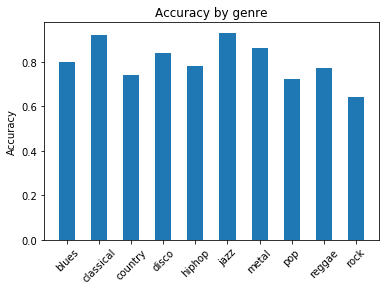

In [36]:
fig = plt_genre_acc(names, percentage)
fig.savefig('./acc_by_genre_p2.png')

In [ ]:
# Save Classifier Weights
classifier.save_weights('./weights/classifier.h5')

In [ ]:
# Evaluate Classifier
X_train_est = np.load('./local_features/X_test_extracted.npy')
classifier_eval = classifier.evaluate(X_test_est, Y_test)

In [38]:
### Save Training History (for plotting) ###
import pickle, datetime
now = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
with open('./train_logs/train_his_{}_{}'.format('FC', now), 'wb') as file_pi:
    pickle.dump(model_his.history, file_pi)